#Практическая работа №1
##Предварительная обработка данных
Выполнила Фонград Анастасия Андреевна КИ21-16/1б Вариант 23
##Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.
##Задачи
Выполнение практической работы предполагает решение следующий задач:
1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных


In [63]:
import pandas as pd
import numpy as np
import sklearn.impute
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from scipy.stats import sigmaclip
from plot_graph import *

Был произведён импорт данных из .xlsx файла

In [64]:
data = pd.read_excel("C:\\Users\\fongr\\Documents\\Мои документы\\Второй курс\\python\\scientificProject\\data\\first_practice_dataframe.xlsx", sheet_name="Sheet1")
CATEGORICAL = ["cat10_proficiencyLevel", "cat9_age"]
NUMERIC = ["num1_24", "num2_24", "num3_24"]
frame = pd.DataFrame(data[CATEGORICAL + NUMERIC])
print(frame)

    cat10_proficiencyLevel            cat9_age      num1_24      num2_24  \
0                 Advanced      below 21 years   907.348256   242.734013   
1                   Novice  59 years and above   962.219776  1035.400665   
2                   Novice  59 years and above  1053.680910  -469.064161   
3                 Advanced  59 years and above  1148.702980  2793.294228   
4                 Advanced  59 years and above  1018.119147  -954.043533   
..                     ...                 ...          ...          ...   
995               Advanced      below 21 years   815.379375  -154.418945   
996                 novice  59 years and above  1195.478914  -572.061291   
997                 Novice      21 to 35 years   762.115010  -596.334731   
998                 Novice  59 years and above   730.372126 -1101.408593   
999               Advanced      36 to 58 years  1015.521911   838.290002   

        num3_24  
0    971.167308  
1    933.449443  
2    950.209325  
3    942.957073

##Визуальный анализ данных
Были построены несколько видов графиков для каждого из столбцов таблицы

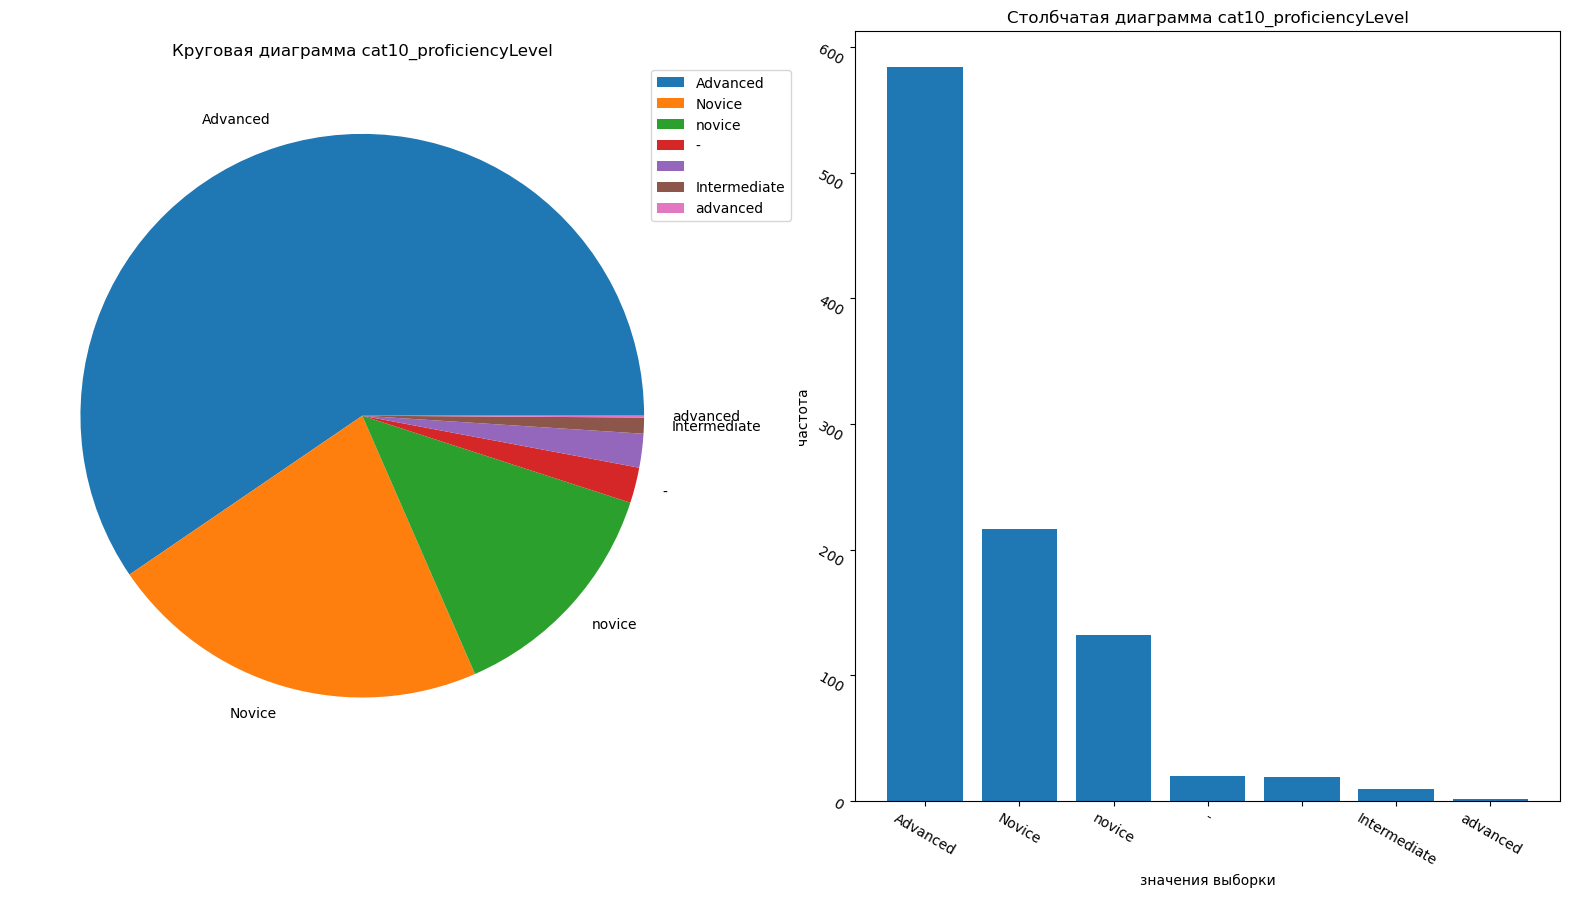

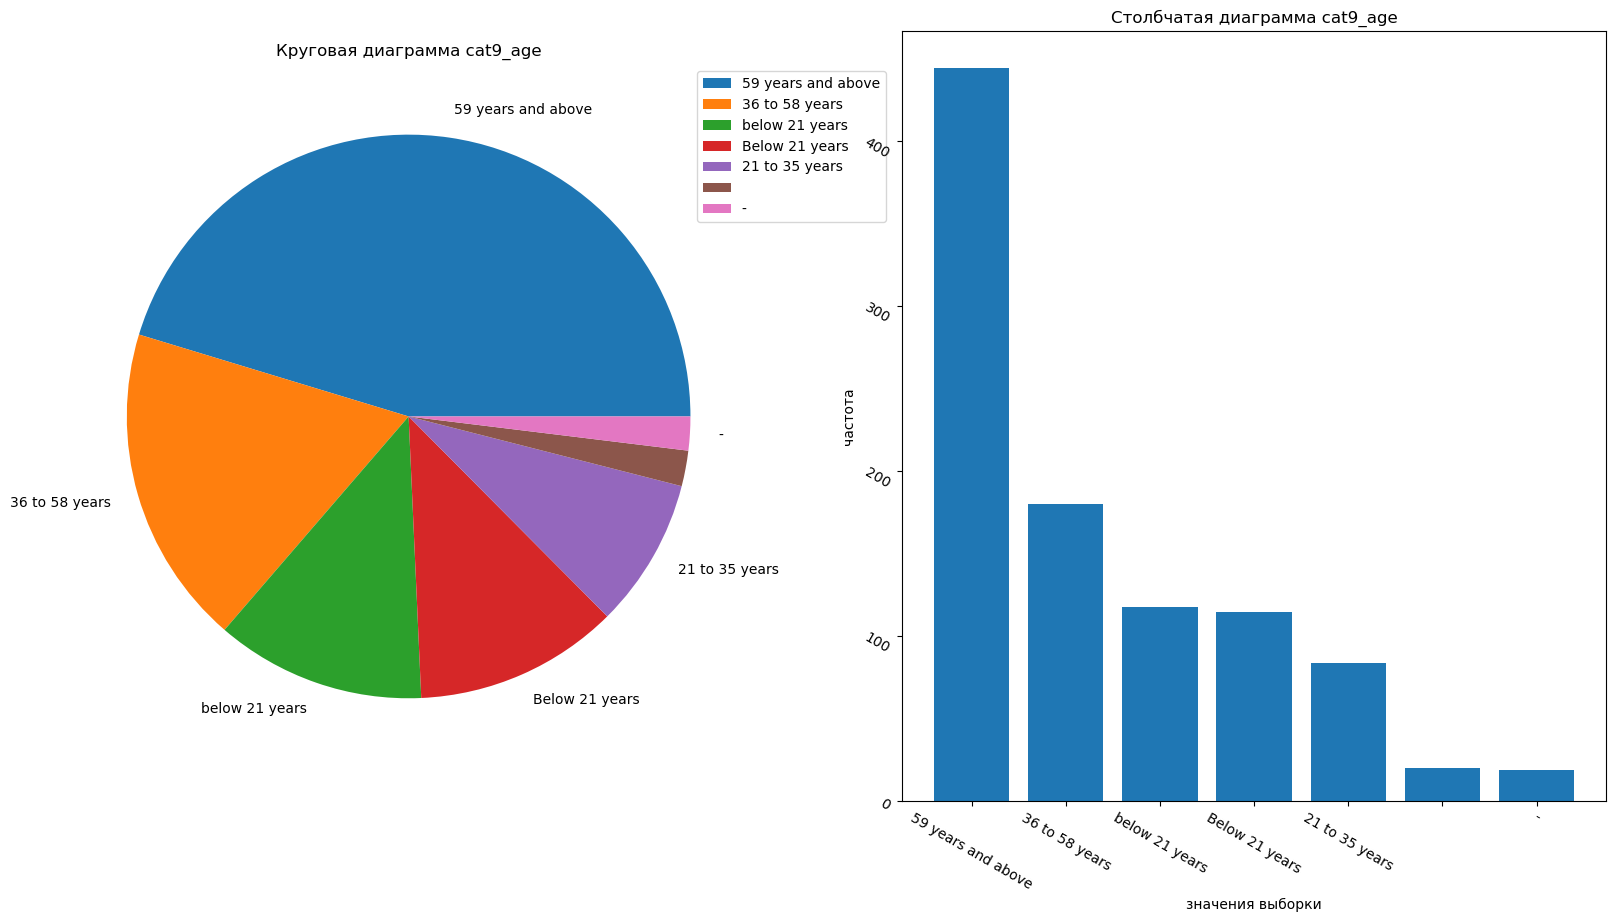

In [65]:
for item in CATEGORICAL:
    build_category_graf(frame, item)

Для построения графиков числовых параметров из них были временно удалены пустые значения. Это позволило избежать ошибок при построении

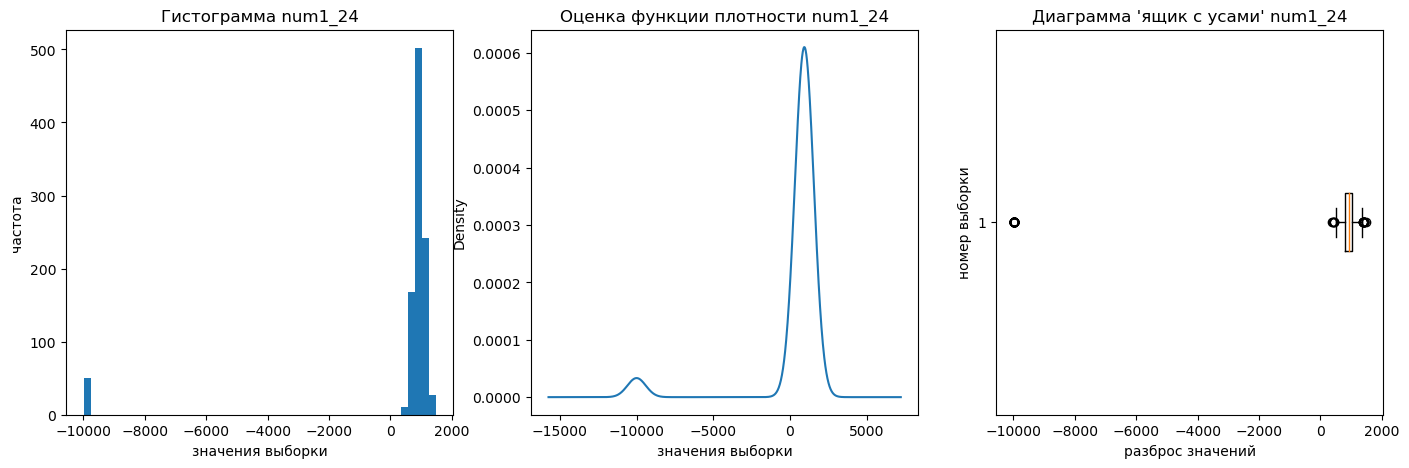

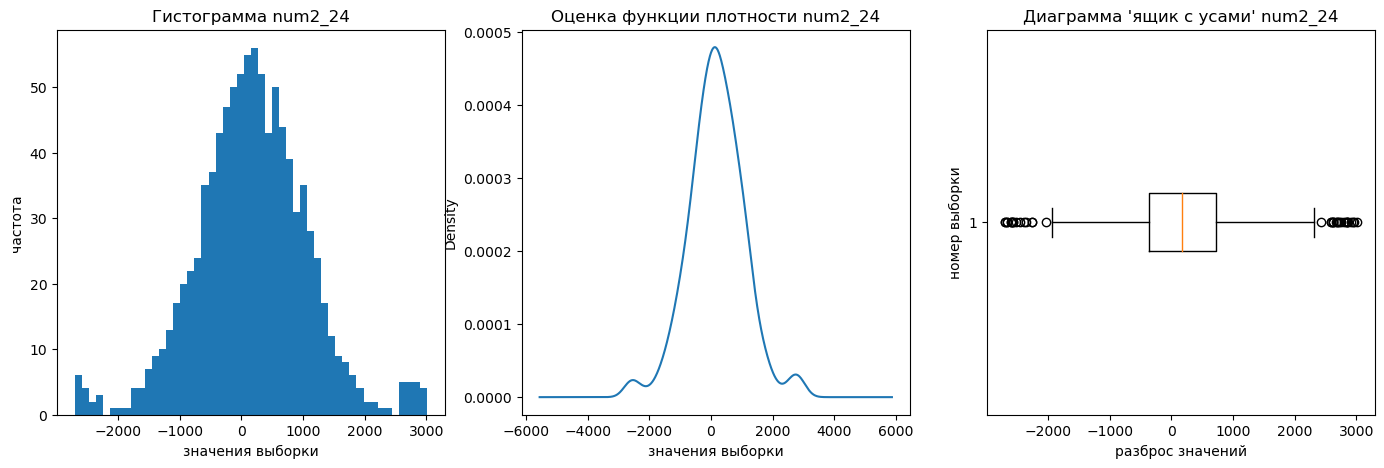

График не может быть построен, т.к. содержит некорректные значения


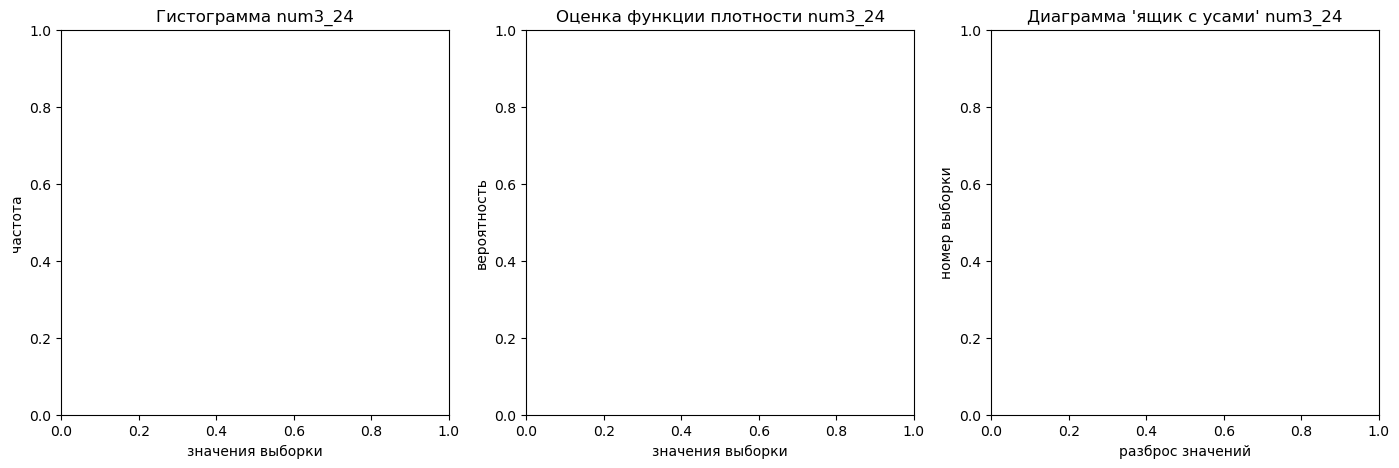

In [66]:
for column in NUMERIC:
    build_numeric_graph(frame, column)

##Поиск аномальных значений
По графикам видно, что некоторые из значений таблицы являются некорректными. Наблюдаются пропуски значений, выбросы, ошибки в именах категорий. Метод info() показывает, что 3 из 5 колонок имеют неверный тип

In [67]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat10_proficiencyLevel  981 non-null    object 
 1   cat9_age                980 non-null    object 
 2   num1_24                 1000 non-null   float64
 3   num2_24                 950 non-null    float64
 4   num3_24                 972 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


###Изменение качественных признаков

Всем пустым значениям был присвоен тип None. Первая буква всех названий категорий была заменена на прописную

In [68]:
for column in CATEGORICAL:
    print(frame[column].value_counts())

Advanced        584
Novice          216
novice          132
-                20
                 19
Intermediate      9
advanced          1
Name: cat10_proficiencyLevel, dtype: int64
59 years and above    444
36 to 58 years        180
below 21 years        118
Below 21 years        115
21 to 35 years         84
                       20
-                      19
Name: cat9_age, dtype: int64


In [69]:
for column in CATEGORICAL:
    frame[column] = frame[column].replace({'-': np.NaN, ' ': np.NaN, None: np.NaN})
    frame[column] = frame[column].apply(lambda x: x.capitalize() if isinstance(x, str) else np.NaN)
    frame[column] = frame[column].astype("category")
    print(frame[column].value_counts())

Advanced        585
Novice          348
Intermediate      9
Name: cat10_proficiencyLevel, dtype: int64
59 years and above    444
Below 21 years        233
36 to 58 years        180
21 to 35 years         84
Name: cat9_age, dtype: int64


Первая и вторая колонки были приведены к категориальному типу

###Изменение количественных признаков
Пустые значения 3 числового признака были заменены на значение NaN.

In [70]:
for column in NUMERIC:
    frame[column] = pd.to_numeric(frame[column], errors='coerce')

Для обновлённого последнего столбца был построен ряд графиков

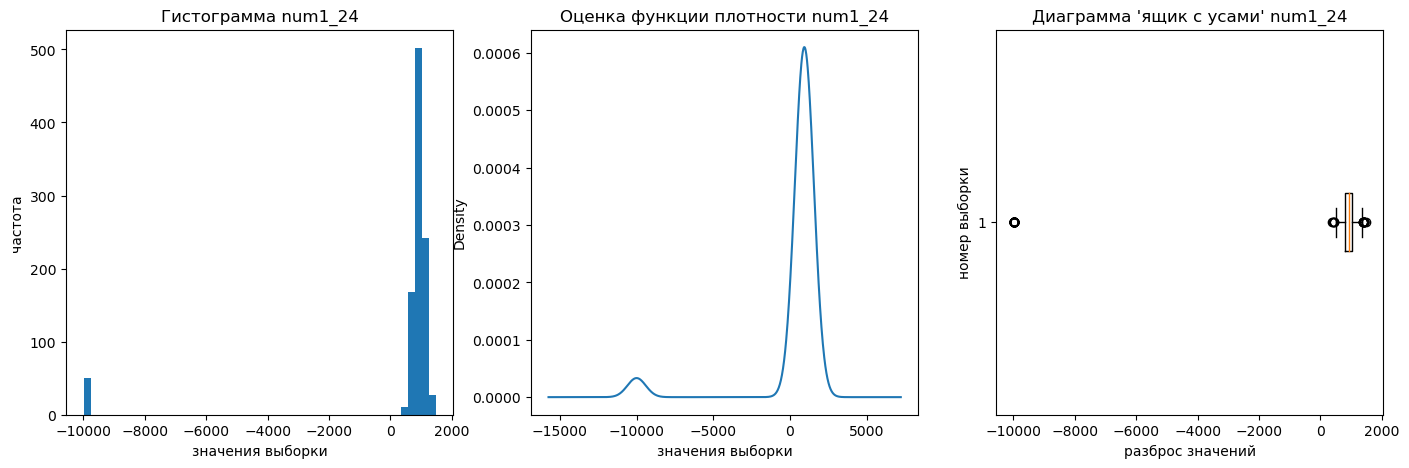

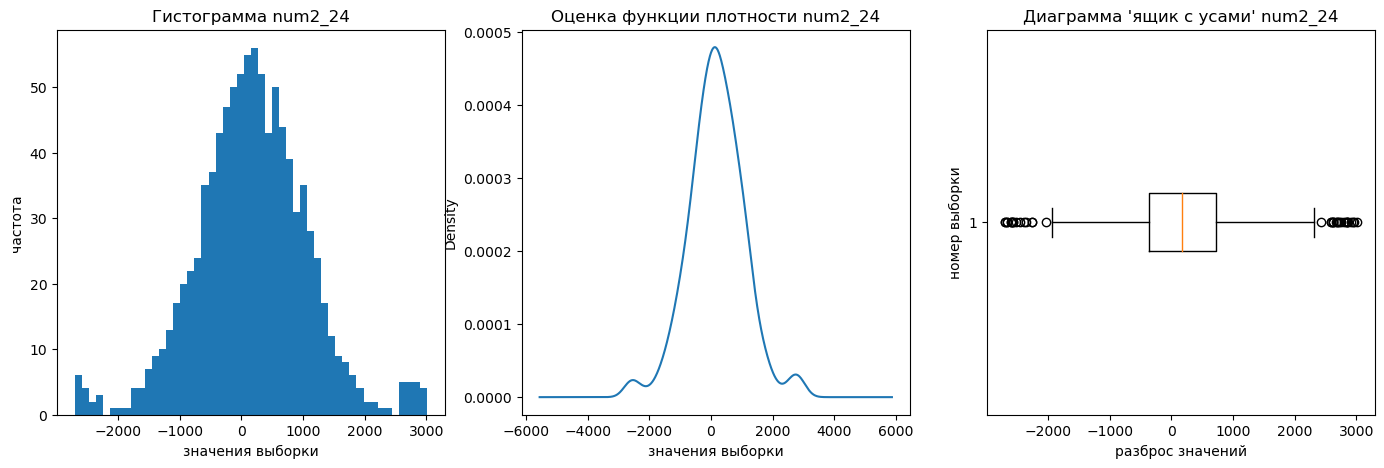

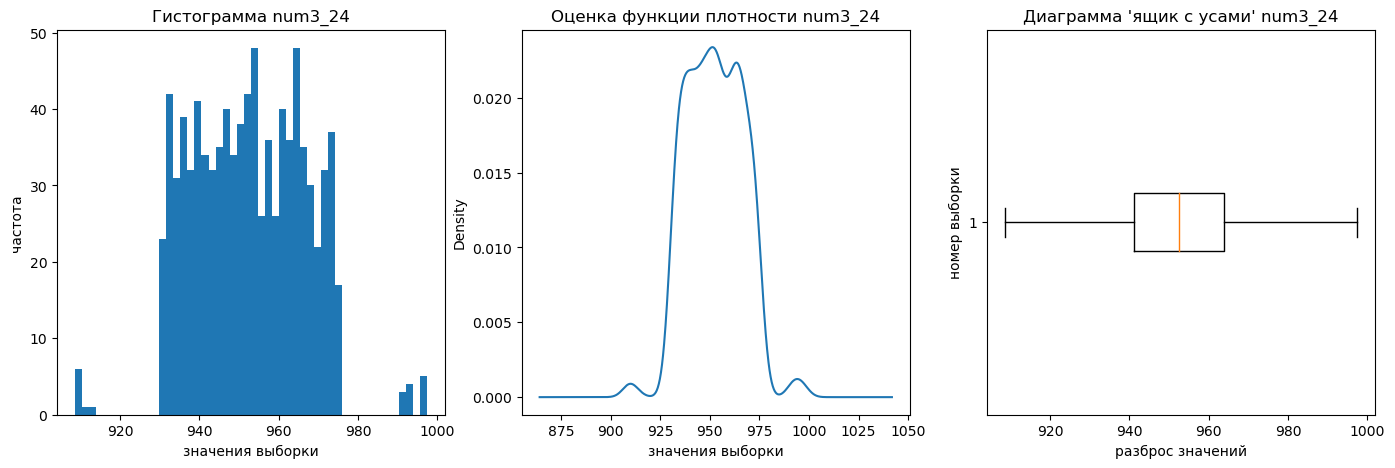

In [71]:
for column in NUMERIC:
    build_numeric_graph(frame, column)

Теперь все качественные признаки имеют тип category, а все количественные - float64

In [72]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cat10_proficiencyLevel  942 non-null    category
 1   cat9_age                941 non-null    category
 2   num1_24                 1000 non-null   float64 
 3   num2_24                 950 non-null    float64 
 4   num3_24                 916 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 25.8 KB


##Удаление аномальных значений
Были сделаны 3 копии исходного фрейма

In [73]:
frame_copy = frame.copy()

###Поиск аномальных значений методом сигм
Были найдены выбросы значений для 1 числового параметра. Строки, содержащие выбросы, были удалены из фрейма.

In [74]:
def sigma_method(data_frame, column):
    """
    Удаляет пропуски методом сигм
    :param data_frame:
    :param column:
    :return:
    """
    data = data_frame.dropna()
    _, low, high = sigmaclip(data[column], 3, 3)
    # c < mean(c) - std(c)*low c > mean(c) + std(c)*high (std - стандартное отклонение)
    dropped_values =  data_frame[column][(data_frame[column] < low) | ( data_frame[column] > high)]
    data_frame = data_frame.drop(dropped_values.index)
    return data_frame

In [75]:
frame_sigma = frame.copy()
for column in NUMERIC:
    frame_sigma = sigma_method(frame_sigma, column)
print(f"Число строк после удаления: {len(frame_sigma)}")

Число строк после удаления: 889


###Поиск аномальных значений методом квантилей

In [76]:
def quantile_method(data_frame, column):
    """
    Удаляет пропуски методом квантилей
    :param data_frame: исходный фрейм данных
    :param column: название колонки для вычисления
    :return: граница начала выбросов
    """
    q25 = data_frame[column].quantile(0.25)
    q75 = data_frame[column].quantile(0.75)
    delta = q75 - q25
    low, high = [(q25 - 1.5 * delta), (q75 + 1.5 * delta)] # Незначительный выброс
    dropped_values =  data_frame[column][(data_frame[column] < low) | ( data_frame[column] > high)]
    data_frame =data_frame.drop(dropped_values.index)
    return data_frame

In [77]:
frame_quantile = frame.copy()
for column in NUMERIC:
    frame_quantile = quantile_method(frame_quantile, column)
print(f"Число строк после удаления: {len(frame_quantile)}")

Число строк после удаления: 900


Ниже представлены гистограммы колонок очищенного от выбросов распределения, полученного методом сигм и методом квантилей

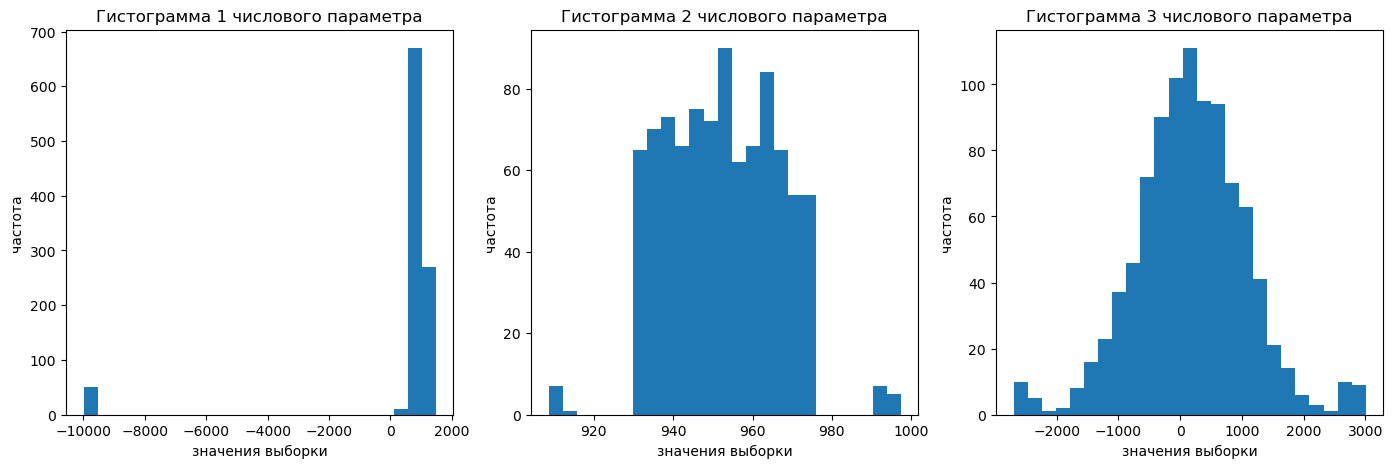

In [78]:
build_three_hists(frame, NUMERIC)

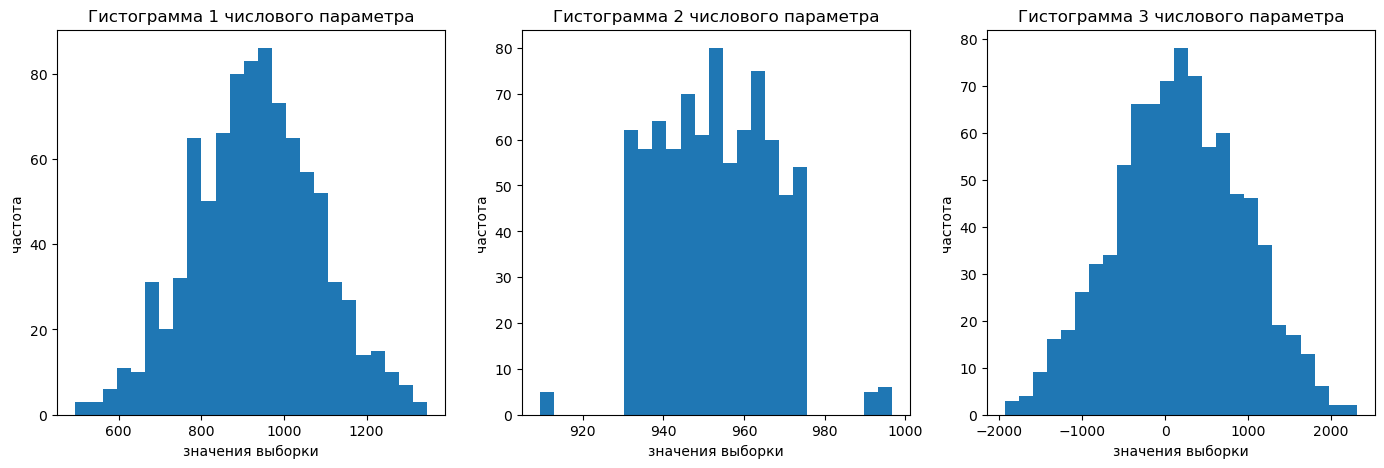

In [79]:
build_three_hists(frame_quantile, NUMERIC)

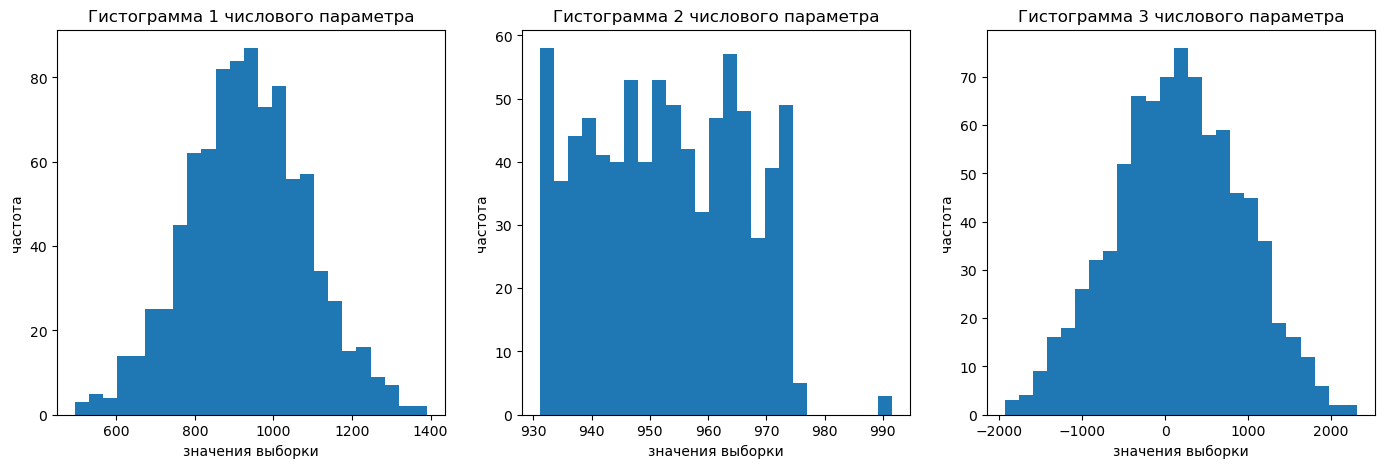

In [80]:
build_three_hists(frame_sigma, NUMERIC)

In [81]:
frame = frame_sigma

In [82]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cat10_proficiencyLevel  836 non-null    category
 1   cat9_age                836 non-null    category
 2   num1_24                 889 non-null    float64 
 3   num2_24                 842 non-null    float64 
 4   num3_24                 812 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 29.8 KB


##Поиск и восстановление пропущенных значений
###Метод k ближайших соседей
Пропуски в третьем количественном признаке были заменены на значения, полученные методом ближайших соседей

In [83]:
col = NUMERIC[-1]
print(frame[col].isna().any())
df_copy = frame.copy()          # копируем датафрейм, чтоб сохранить значение колонок до заполнения
knn_inputer = sklearn.impute.KNNImputer()
frame[[col]] = knn_inputer.fit_transform(df_copy[[col]])
print(frame[col].isna().any())

True
False


Для устранения пропусков в первом качественном признаке методом k ближайших соседей, их значения были приведены к целочисленным кодам

In [84]:
first_column = CATEGORICAL[0]
df_filled = frame.copy()
nan_index = df_filled[first_column][df_filled[first_column].isna() == True].index[0]
imputer = sklearn.impute.KNNImputer(n_neighbors=5)
le = LabelEncoder()
df_filled[first_column] = le.fit_transform(frame[first_column])
df_filled[first_column] = df_filled[first_column].replace({df_filled[first_column][nan_index]: np.nan})
df_filled[first_column] = imputer.fit_transform(df_filled[[first_column]])
df_filled[first_column] = df_filled[first_column].apply(lambda x: round(x))
df_filled[first_column] = le.inverse_transform(df_filled[first_column])
frame = df_filled
print(frame[first_column].isna().any())

False


Пропуски в 1 и 2 количественных признаках были заполнены средним и медианным значениями соответственно. Во втором качественном - самым популярным значением

In [85]:
first = NUMERIC[0]
average = frame[first].mean()
frame[first] = frame[first].fillna(average)
print("Наличие Nan в первом столбце:", frame[first].isna().any())
second = NUMERIC[1]
median = frame[second].median()
frame[second] = frame[second].fillna(median)
print("Наличие Nan во втором столбце:", frame[second].isna().any())
third = CATEGORICAL[1]
mode = frame[third].value_counts().keys()[0]
frame[third] = frame[third].fillna(mode)
print("Наличие Nan в последнем столбце:", frame[third].isna().any())
frame

Наличие Nan в первом столбце: False
Наличие Nan во втором столбце: False
Наличие Nan в последнем столбце: False


,cat10_proficiencyLevel,cat9_age,num1_24,num2_24,num3_24
0,Advanced,Below 21 years,907.348256,242.734013,971.167308
1,Novice,59 years and above,962.219776,1035.400665,933.449443
2,Novice,59 years and above,1053.680910,-469.064161,950.209325
4,Advanced,59 years and above,1018.119147,-954.043533,947.163814
5,Novice,59 years and above,781.003970,-406.560281,948.073989
...,...,...,...,...,...
995,Advanced,Below 21 years,815.379375,-154.418945,961.201375
996,Novice,59 years and above,1195.478914,-572.061291,954.136037
997,Novice,21 to 35 years,762.115010,-596.334731,955.746237
998,Novice,59 years and above,730.372126,-1101.408593,953.369459


##Преобразование данных
###Кодировка категориальных признаков
Первый категориальный признак был закодирован с помощью one-hot encoding

In [86]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   cat10_proficiencyLevel  889 non-null    object  
 1   cat9_age                889 non-null    category
 2   num1_24                 889 non-null    float64 
 3   num2_24                 889 non-null    float64 
 4   num3_24                 889 non-null    float64 
dtypes: category(1), float64(3), object(1)
memory usage: 68.1+ KB


In [87]:
enc = OneHotEncoder(min_frequency=6, sparse_output=False, categories='auto')
enc_df = pd.DataFrame(enc.fit_transform(frame[[CATEGORICAL[0]]]), columns=enc.get_feature_names_out())
frame = frame.join(enc_df)
frame.head(10)

,cat10_proficiencyLevel,cat9_age,num1_24,num2_24,num3_24,cat10_proficiencyLevel_Advanced,cat10_proficiencyLevel_Intermediate,cat10_proficiencyLevel_Novice
0,Advanced,Below 21 years,907.348256,242.734013,971.167308,1.0,0.0,0.0
1,Novice,59 years and above,962.219776,1035.400665,933.449443,0.0,0.0,1.0
2,Novice,59 years and above,1053.680910,-469.064161,950.209325,0.0,0.0,1.0
4,Advanced,59 years and above,1018.119147,-954.043533,947.163814,0.0,0.0,1.0
5,Novice,59 years and above,781.003970,-406.560281,948.073989,1.0,0.0,0.0
6,Advanced,21 to 35 years,902.478277,752.799008,934.161276,1.0,0.0,0.0
7,Advanced,59 years and above,839.743781,854.863999,966.103548,1.0,0.0,0.0
8,Advanced,Below 21 years,1034.997244,858.709287,968.492396,1.0,0.0,0.0
10,Advanced,59 years and above,1013.914427,867.618096,946.308634,0.0,0.0,1.0
11,Novice,59 years and above,950.322606,-1124.427462,940.745295,1.0,0.0,0.0


Второй категориальный признак был закодирован с помощью label encoding

In [88]:
frame[CATEGORICAL[1] + "_num"] = le.fit_transform(frame[CATEGORICAL[1]])
frame[[CATEGORICAL[1], CATEGORICAL[1] + "_num"]]

,cat9_age,cat9_age_num
0,Below 21 years,3
1,59 years and above,2
2,59 years and above,2
4,59 years and above,2
5,59 years and above,2
...,...,...
995,Below 21 years,3
996,59 years and above,2
997,21 to 35 years,0
998,59 years and above,2


###Преобразование количественных признаков
Нормализованный набор данных всегда будет иметь значения в диапазоне от 0 до 1.
Стандартизированный набор данных будет иметь среднее значение 0 и стандартное отклонение 1
Первый количественный признак был приведён к нормализованному виду

In [89]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(frame[[NUMERIC[0]]])
frame[NUMERIC[0] + "_scaled"] = scaled_values

Второй и третий количественные признаки были приведены к стандартизованному виду

In [90]:
scaler_std = StandardScaler()
scaled_values = scaler_std.fit_transform(frame[NUMERIC[1:]])
frame[[NUMERIC[1] + "_scaled", NUMERIC[2] + "_scaled"]] = scaled_values

In [91]:
frame.describe()

,num1_24,num2_24,num3_24,cat10_proficiencyLevel_Advanced,cat10_proficiencyLevel_Intermediate,cat10_proficiencyLevel_Novice,cat9_age_num,num1_24_scaled,num2_24_scaled,num3_24_scaled
count,889.000000,889.000000,889.000000,792.000000,792.000000,792.000000,889.000000,889.000000,8.890000e+02,8.890000e+02
mean,933.856435,158.530873,952.813046,0.580808,0.069444,0.349747,1.897638,0.490648,1.998152e-18,8.997677e-15
std,152.314030,749.022608,12.342030,0.493739,0.254369,0.477191,0.852715,0.169789,1.000563e+00,1.000563e+00
min,493.706337,-1936.052726,931.064026,0.000000,0.000000,0.000000,0.000000,0.000000,-2.797997e+00,-1.763183e+00
25%,833.152724,-329.911240,942.988611,0.000000,0.000000,0.000000,1.000000,0.378391,-6.524730e-01,-7.964625e-01
50%,933.100258,163.845318,952.813046,1.000000,0.000000,0.000000,2.000000,0.489805,7.099167e-03,1.843308e-14
75%,1033.784261,665.460160,963.051677,1.000000,0.000000,1.000000,2.000000,0.602041,6.771687e-01,8.300412e-01
max,1390.784809,2309.473570,991.577898,1.000000,1.000000,1.000000,3.000000,1.000000,2.873282e+00,3.142649e+00


##Выводы
В процессе работы была произведена первичная обработка исходных данных. Было произведено извлечение из фрейма аномальных значений, пропуски в данных были заполнены, все столбцы приведены к стандартизированному виду.
Ниже представлено сравнение исходных и итоговых графиков

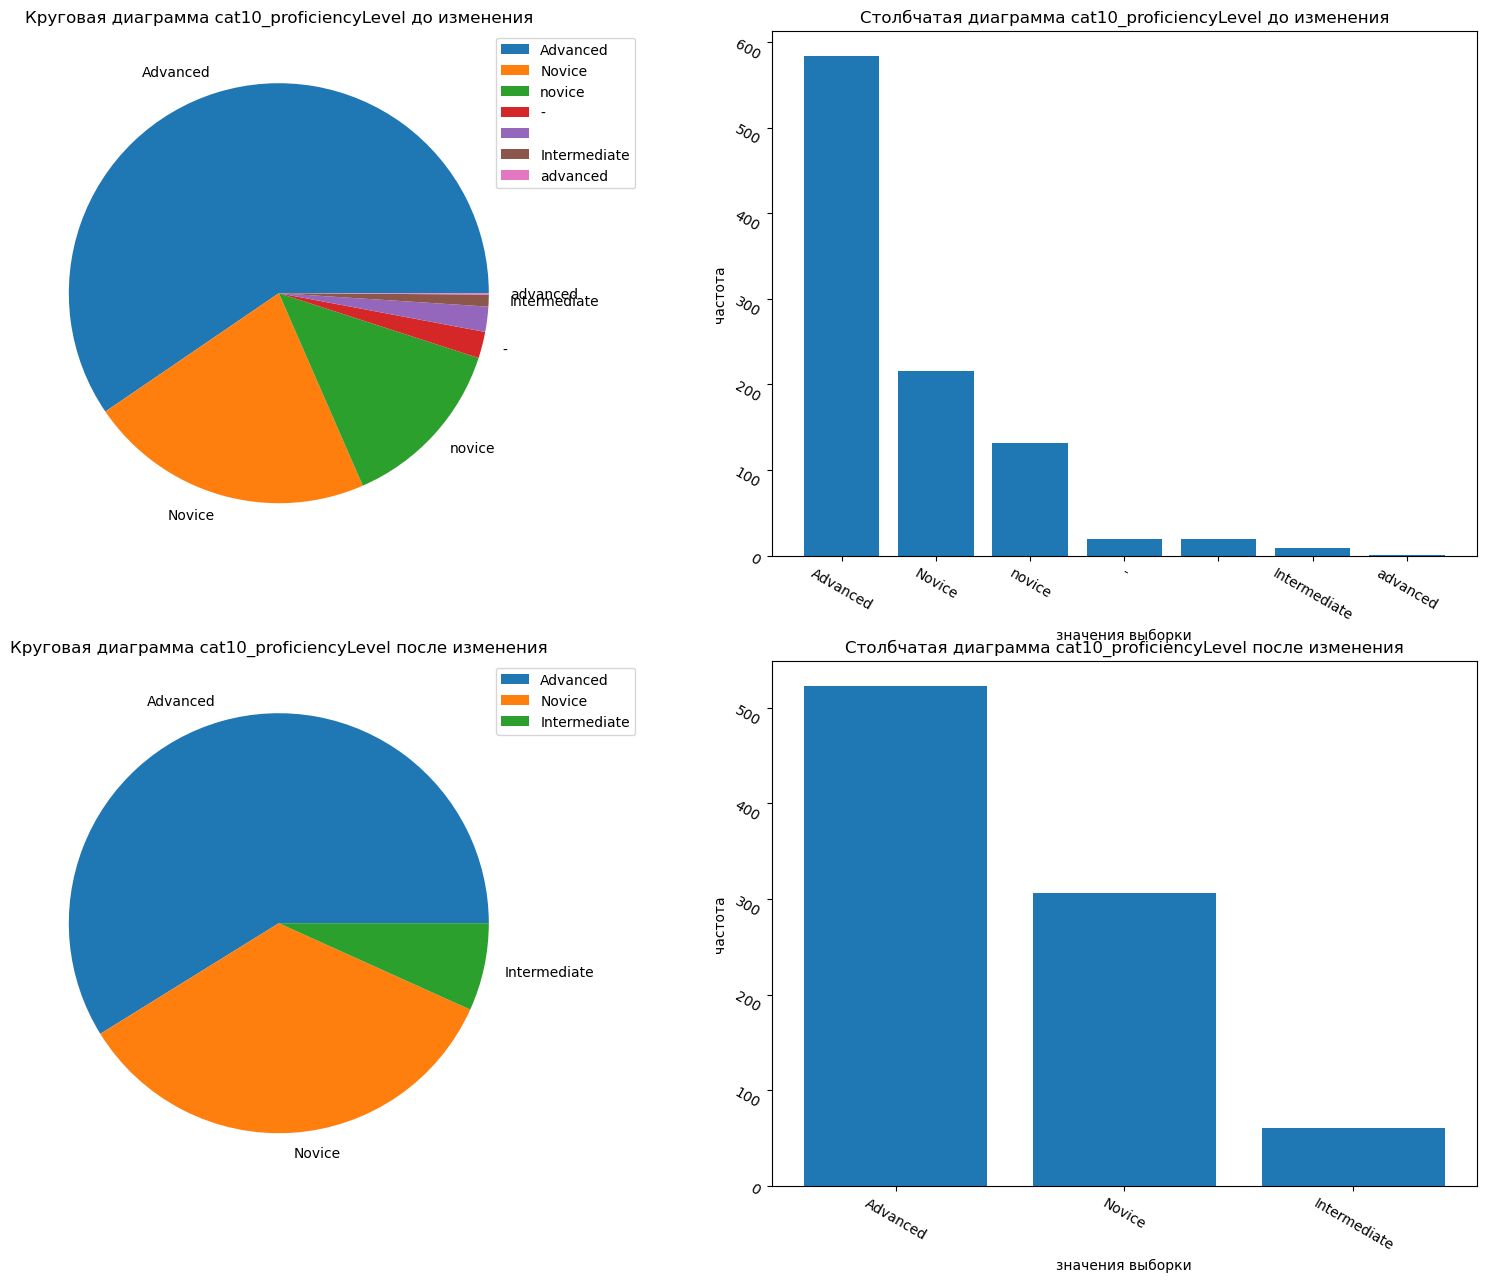

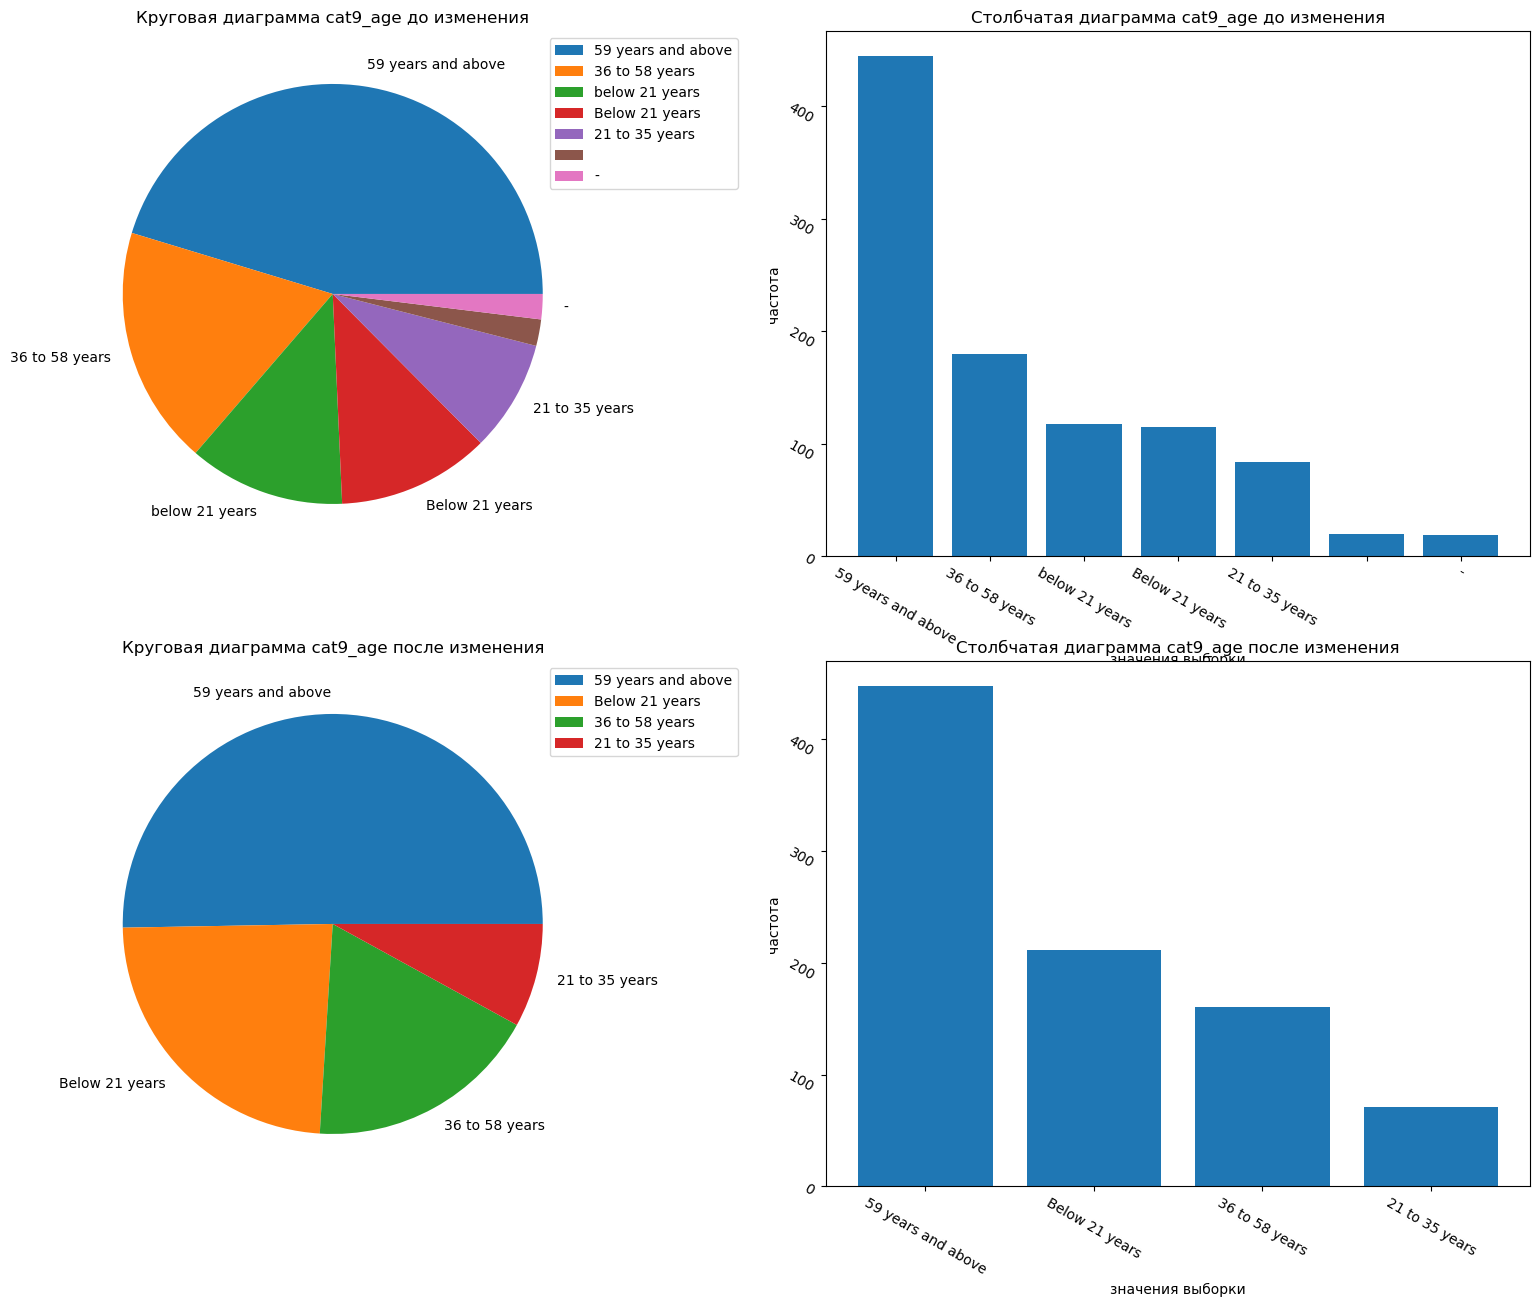

In [92]:
for column in CATEGORICAL:
    compare_category_graf(data, frame, column, column)

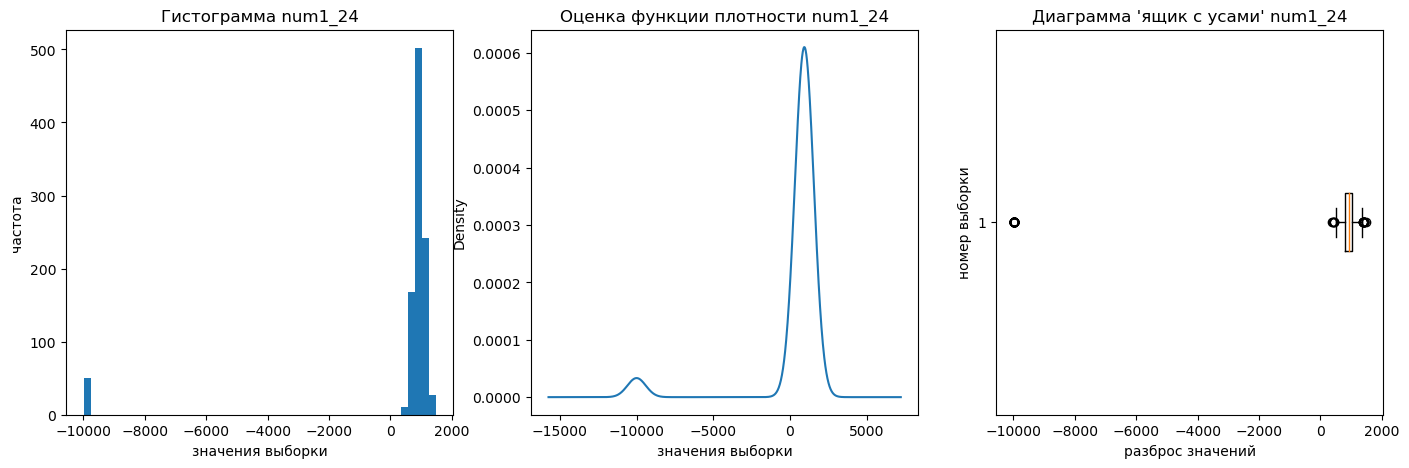

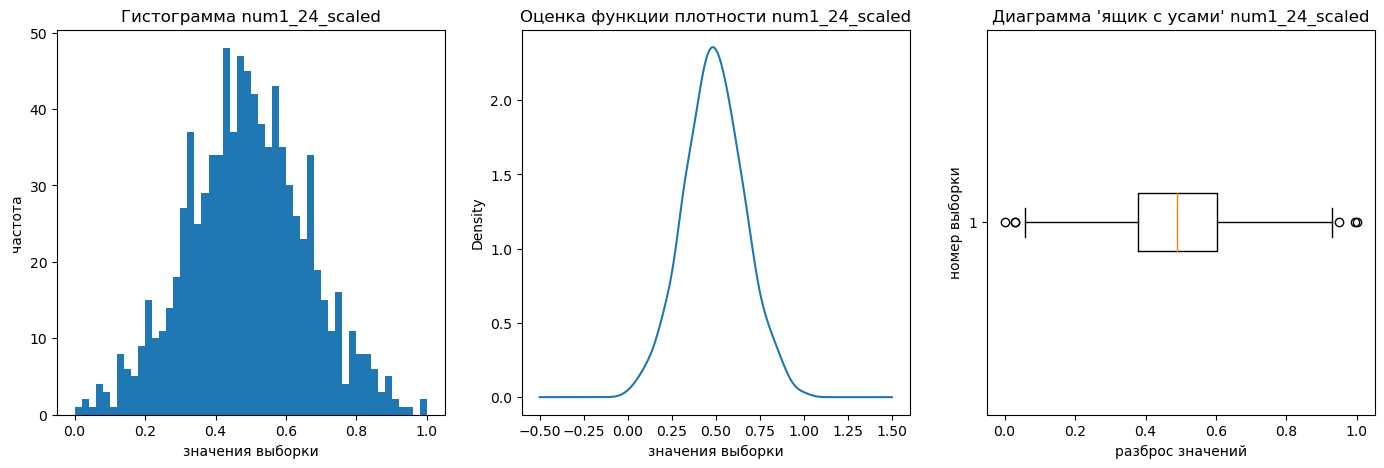

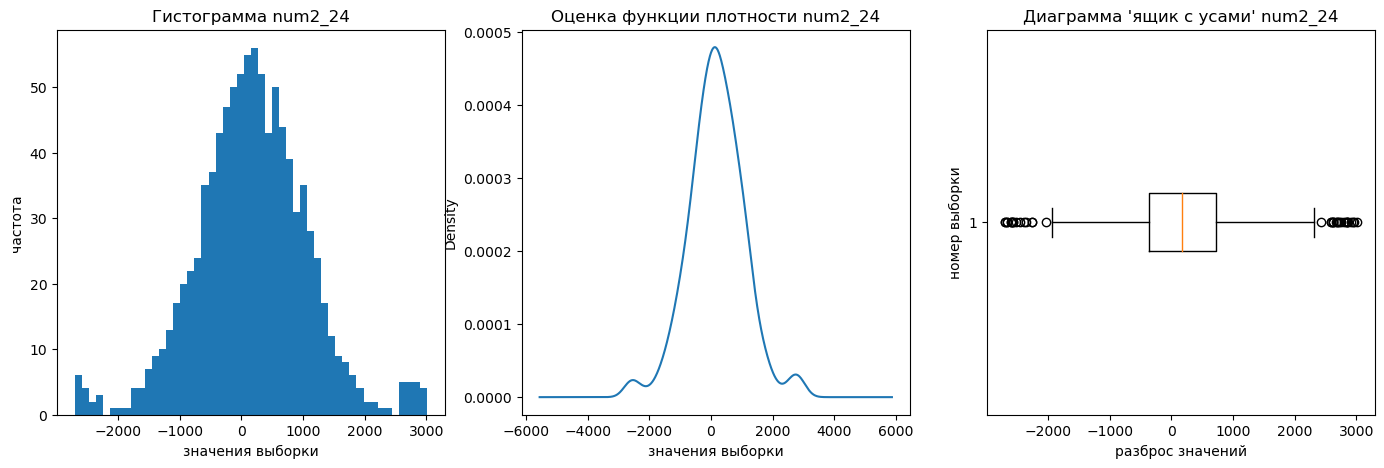

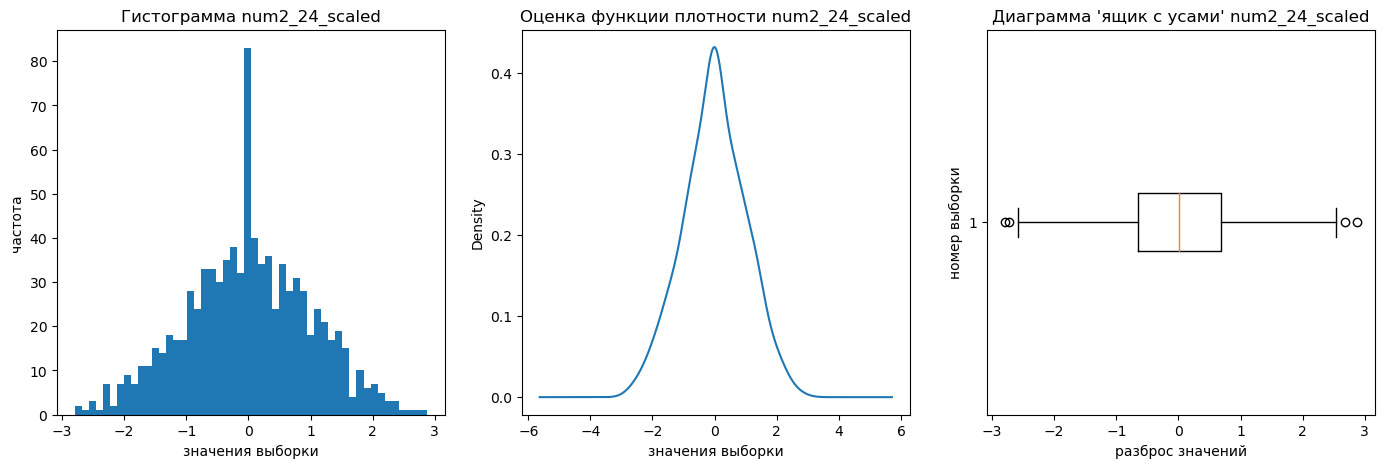

График не может быть построен, т.к. содержит некорректные значения


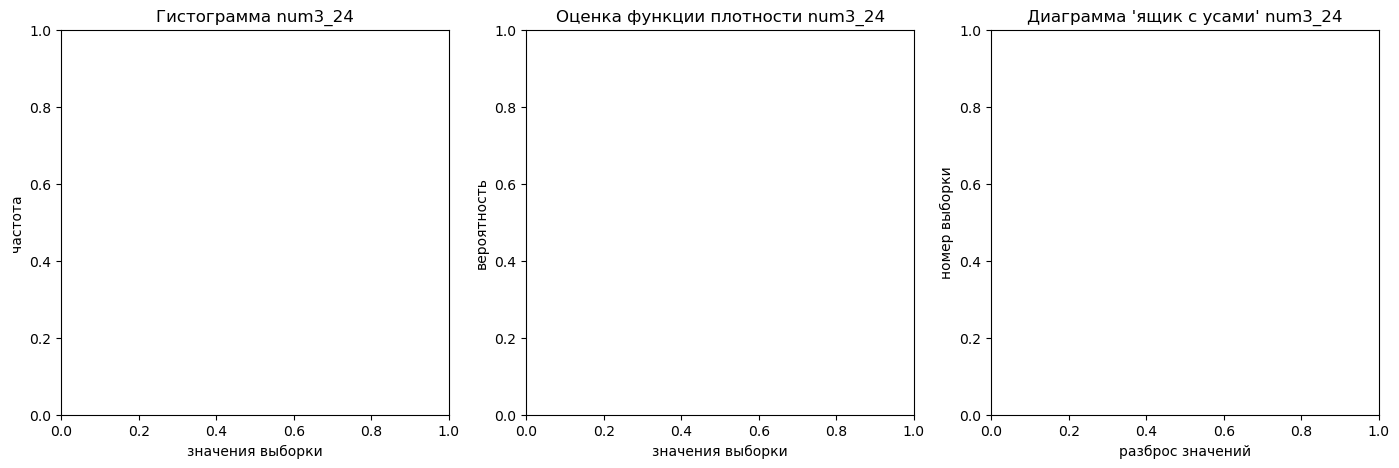

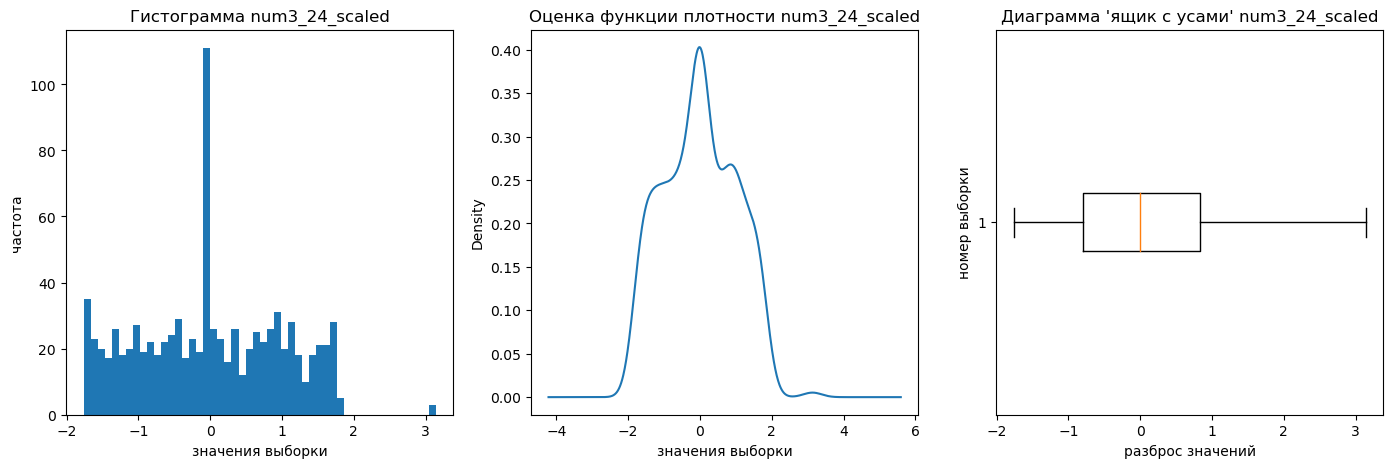

In [93]:
for column in NUMERIC:
    build_numeric_graph(data, column)
    build_numeric_graph(frame, column + "_scaled")